The central urban planning commitee of Banana Republic asked you to help them with the forecast of bus demands of municipalities. And they provide a nice dataset to support you (https://pi.works/3w8IJbV). 

The dataset includes two measurements for an hour for the number of used buses in each municipality, each measurement is timestamped. The dataset format is as follows (comma separated values):
MUNICIPALITY_ID, TIMESTAMP, USAGE, TOTAL_CAPACITY
where municipality_id is an anonymization to disguise the actual names, timestamp represents the exact time of the measurement, usage is the number of buses in use at the time of measurement and total_capacity represents the total number of buses in the municipality. 

There are 10 municipalities (ids from 0 to 9), and two measurements for an hour.
The committee asks you to forecast the hourly bus usages for next week for each municipality. Hence you can aggregate the two measurements for an hour by taking the max value (sum would not be a nice idea for the obvious reasons) for each hour, and you should model this data with a time series model of your selection. (It would be a nice idea to implement a very simple baseline model first, and then try to improve the accuracy by introducing more complex methods eventually. 

The bare minimum requirement of the task is one simple baseline and one complex method.)
The committee says that they will use the last two weeks (starting from 2017-08-05 to 2017-08-19) as assessment (test) data, hence your code should report the error (in the criterion you chose for the task) for the last two weeks. You may use true values for the prediction of the last week of test data, then combine the error of the first and last week of the test separately.

Keep in mind that the dataset has missing data, hence a suitable missing data interpolation would be useful.

In [68]:
import pandas as pd
import statsmodels.api as sm
import datetime
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',FutureWarning)
warnings.simplefilter('ignore')

In [69]:
# load data
dt = pd.read_csv("municipality_bus_utilization.csv")
dt.index = pd.to_datetime(dt['timestamp'])
del dt['timestamp']

In [88]:
def get_municipal(dt,municipal=0):
    # select municipal (assuming all are independent and have different dynamics at play)
    dt0 = dt[dt['municipality_id']==municipal] # select municipal
    dt0_max = dt[dt['municipality_id']==municipal]['total_capacity'][0]
    del dt0['municipality_id'] # not important anymore
    del dt0['total_capacity'] # never changes
    # test data and train data are seperated. Both are resampled Hourly by the max value for each hour.
    # then missing values are interpolated.
    dt0t = dt0[dt0.index >= '2017-08-05'].resample('H').max().interpolate(method='quadratic') # test data
    dt0 = dt0[dt0.index < '2017-08-05'].resample('H').max().interpolate(method='quadratic') # train data
    dt0[dt0['usage']<=0]=0 # eliminate negative number of usage
    dt0t[dt0t['usage']<=0]=0 # eliminate negative number of usage

    return (dt0,dt0t,dt0_max)



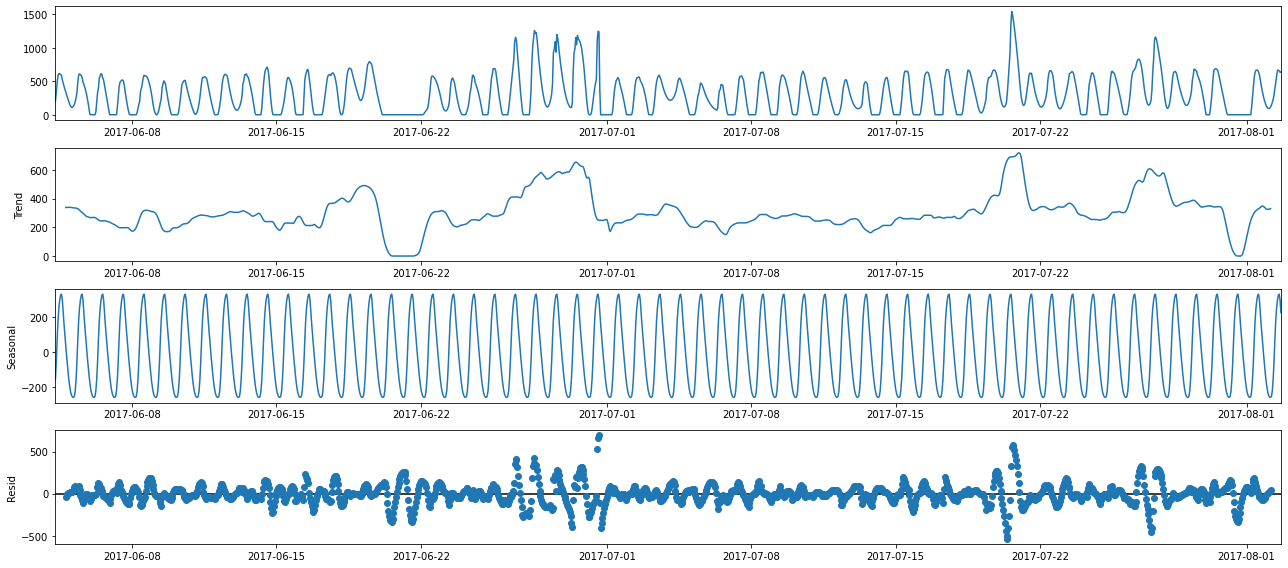

In [255]:
# analyze first municipal step by step. After which I will assume all have similar dynamics and models.
dt0,dt0t,dt0_max = get_municipal(dt,0)

decomposition = sm.tsa.seasonal_decompose(dt0, model='additive')
fig = decomposition.plot()
# definite hourly seasonality (seasonal plot).
# residues suggest that trends are somewhat regular.

In [256]:
result = sm.tsa.adfuller(dt0.diff().dropna(),regression='c')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    
    
# Time series is statistically stationary because ADF test result is less than critical values. 
# (Obvious in retrospect, since bus demand would not drastically change under normal circumstances)  

ADF Statistic: -9.904196373268167
n_lags: 3.296596968729812e-17
p-value: 3.296596968729812e-17
Critial Values:
   1%, -3.435029521805029
Critial Values:
   5%, -2.8636066747959186
Critial Values:
   10%, -2.5678702903061223


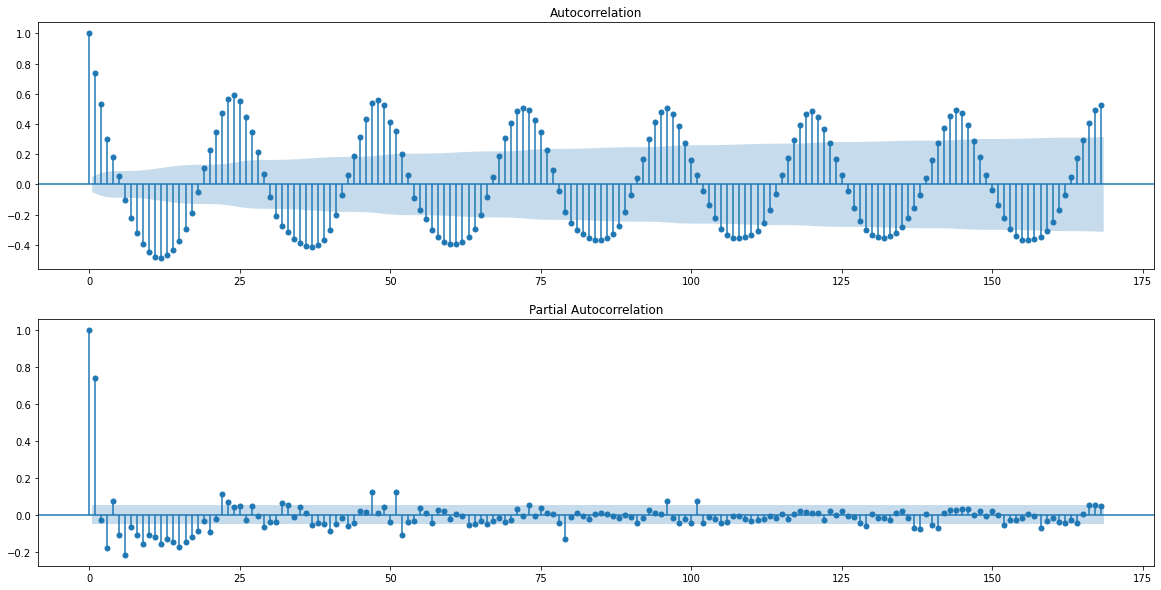

In [257]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(dt0.diff().dropna(), lags=24*7, ax=ax[0]) # for a week: 24 hours * 7 days
fig = sm.graphics.tsa.plot_pacf(dt0.diff().dropna(), lags=24*7, ax=ax[1])
plt.show()

# ACF and PACF suggest daily predictable cycles (obviously) and hourly patterns.

In [258]:
# base model fit
arima = sm.tsa.arima.ARIMA(dt0, order=(2, 0, 1)).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  usage   No. Observations:                 1426
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -7571.956
Date:                Thu, 28 Oct 2021   AIC                          15153.911
Time:                        14:48:27   BIC                          15180.225
Sample:                    06-04-2017   HQIC                         15163.739
                         - 08-02-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        302.6753     21.223     14.262      0.000     261.079     344.271
ar.L1          1.7681      0.010    173.965      0.000       1.748       1.788
ar.L2         -0.8364      0.011    -78.148      0.000      -0.857      -0.815
ma.L1         -0.1638      0.013    -12.225      0.000      -0.190      -0.138
sigma2      2388.5668     18.464    129.361      0.000    2352.377    2424.756
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            364983.09
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                            -0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        81.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

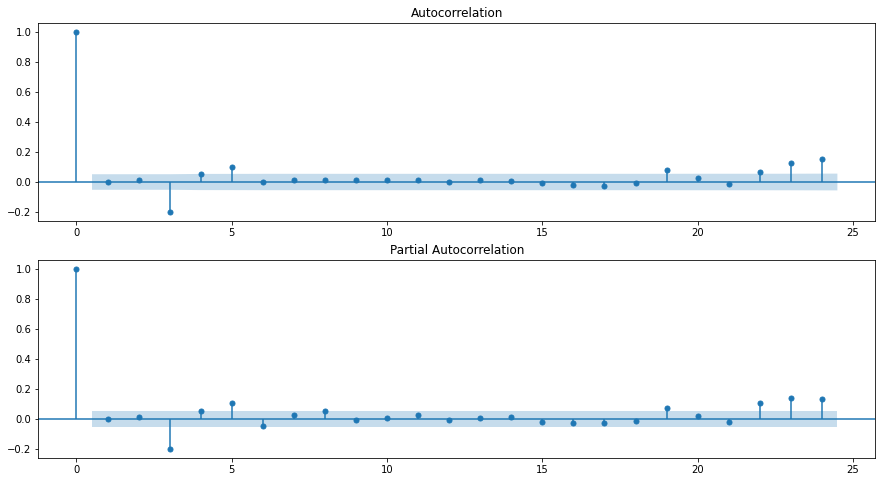

In [259]:
res = arima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=24, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=24, ax=ax[1])
plt.show()

# fitted model residuals

In [260]:
# model performance based on last two week.
pred = arima.predict(dt0t.index[0],dt0t.index[-1])
print('ARIMA model MSE:{}'.format(mean_squared_error(dt0t,pred)))

ARIMA model MSE:167850.3112422408


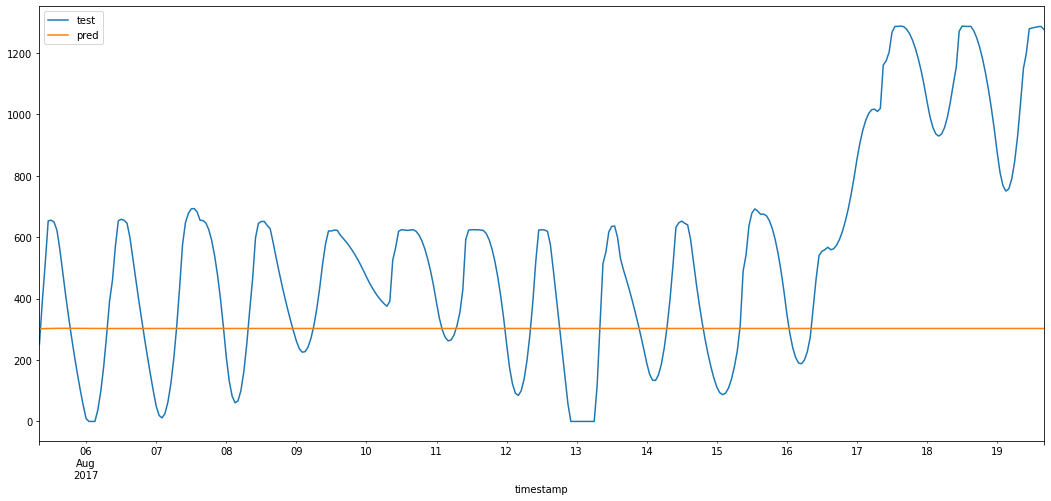

In [261]:
# test data vs prediction
pd.DataFrame({'test':dt0t['usage'],'pred':pred}).plot()
plt.show()

#Arima misses hourly seasons, not suprising!

In [262]:
# complex model fit
sarima = sm.tsa.statespace.SARIMAX(dt0,order=(2,0,1),seasonal_order=(1,1,0,24),enforce_stationarity=False, enforce_invertibility=False,freq='H').fit()
sarima.summary()
# daily period added as seasonality parameter (24 for 24 hours)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               usage   No. Observations:                 1426
Model:             SARIMAX(2, 0, 1)x(1, 1, [], 24)   Log Likelihood               -7459.385
Date:                             Thu, 28 Oct 2021   AIC                          14928.770
Time:                                     14:48:38   BIC                          14954.904
Sample:                                 06-04-2017   HQIC                         14938.548
                                      - 08-02-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4898      0.034     44.438      0.000       1.424       1.555
ar.L2         -0.5564      0.034    -16.138      0.000      -0.624      -0.489
ma.L1         -0.1045      0.036     -2.879      0.004      -0.176      -0.033
ar.S.L24      -0.4591      0.006    -83.312      0.000      -0.470      -0.448
sigma2      2993.6399     23.621    126.735      0.000    2947.343    3039.937
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):            244325.75
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        68.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

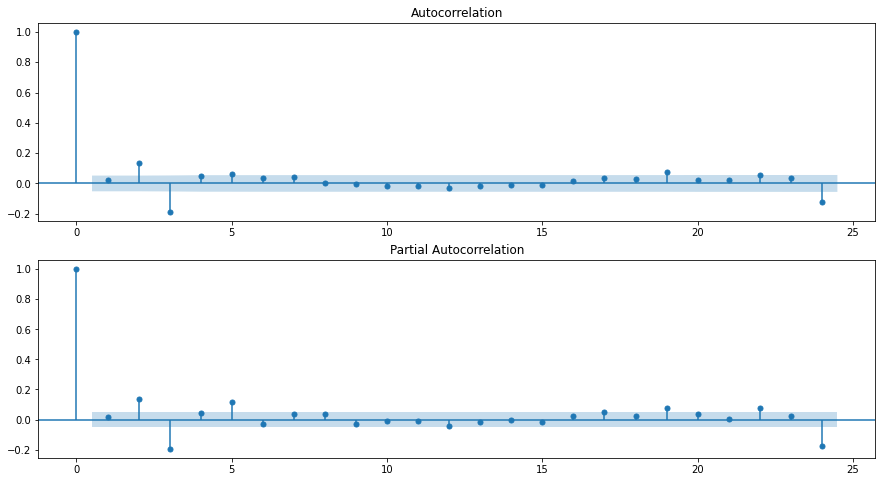

In [263]:
res = sarima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=24, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=24, ax=ax[1])
plt.show()

# fitted model residuals

In [264]:
# model performance based on last two week.
pred = sarima.predict(dt0t.index[0],dt0t.index[-1])
print('SARIMA model MSE:{}'.format(mean_squared_error(dt0t,pred)))

# improvement upon base model (Not suprising)

SARIMA model MSE:113666.11415919366


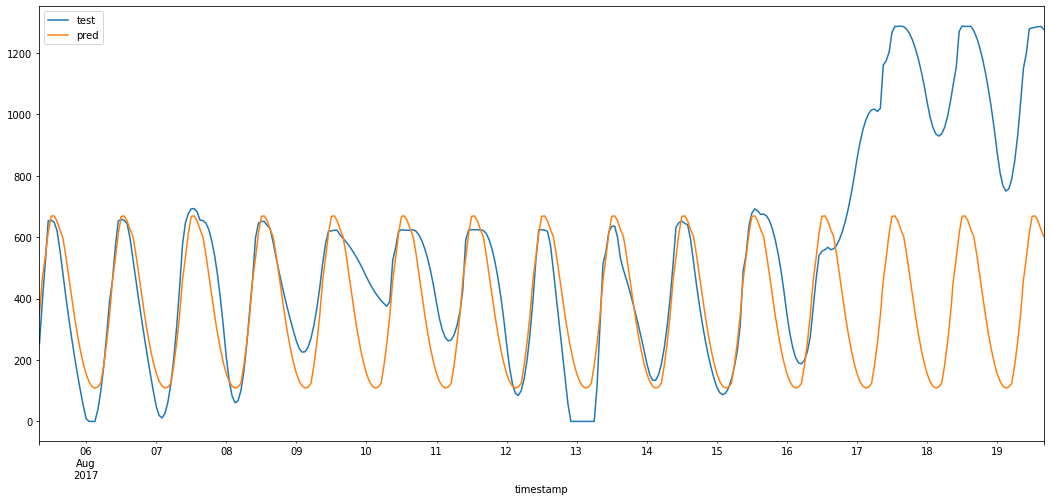

In [265]:
# test data vs prediction
pd.DataFrame({'test':dt0t['usage'],'pred':pred}).plot()
plt.show()

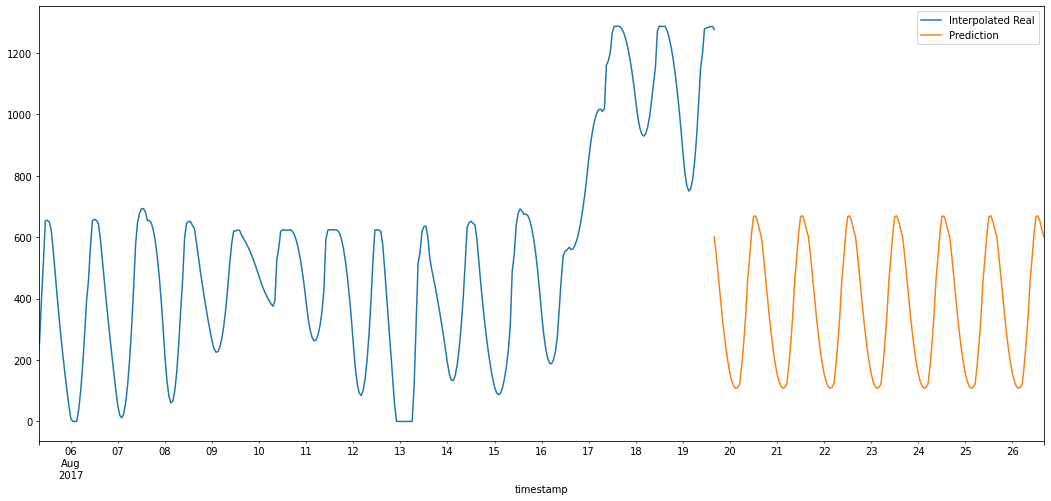

In [266]:
#predict next week
pred = sarima.predict(dt0t.index[-1],dt0t.index[-1]+pd.Timedelta(days=7)).apply(np.floor) # No half people!
#pred[pred>dt0_max]=dt0_max
fig2, ax2 = plt.subplots()
dt0t.plot(ax=ax2)
pred.plot(ax=ax2)
ax2.legend(["Interpolated Real","Prediction"])

In [267]:
# hourly usage numbers for the next two weeks
pred 

2017-08-19 16:00:00    601.0
2017-08-19 17:00:00    544.0
2017-08-19 18:00:00    478.0
2017-08-19 19:00:00    410.0
2017-08-19 20:00:00    345.0
                       ...  
2017-08-26 12:00:00    667.0
2017-08-26 13:00:00    669.0
2017-08-26 14:00:00    652.0
2017-08-26 15:00:00    624.0
2017-08-26 16:00:00    601.0
Freq: H, Name: predicted_mean, Length: 169, dtype: float64

In [281]:
# let turn this to a function assuming similar models will work just fine. (It did not work fine :) please see the comments at the end!)
def get_pred(dt,municipal):
    dt0,dt0t,dt0_max = get_municipal(dt,municipal)
    sarima = sm.tsa.statespace.SARIMAX(dt0,order=(2,0,1),seasonal_order=(1,1,0,24),enforce_stationarity=False, enforce_invertibility=False,freq='H').fit()
    pred = sarima.predict(dt0t.index[0],dt0t.index[-1])
    error = mean_squared_error(dt0t,pred)
    pred = sarima.predict(dt0t.index[-1],dt0t.index[-1]+pd.Timedelta(days=7)).apply(np.floor) # No half people!
    #pred[pred>dt0_max]=dt0_max
    fig, ax2 = plt.subplots()
    dt0t.plot(ax=ax2)
    pred.plot(ax=ax2)
    ax2.legend(["Interpolated Real","Prediction"])
    
    return fig, pred, error

Sarimax MSE error: 3026.7460261201427
2017-08-19 16:00:00    366.0
2017-08-19 17:00:00    334.0
2017-08-19 18:00:00    304.0
2017-08-19 19:00:00    275.0
2017-08-19 20:00:00    247.0
                       ...  
2017-08-26 12:00:00    416.0
2017-08-26 13:00:00    416.0
2017-08-26 14:00:00    410.0
2017-08-26 15:00:00    397.0
2017-08-26 16:00:00    366.0
Freq: H, Name: predicted_mean, Length: 169, dtype: float64


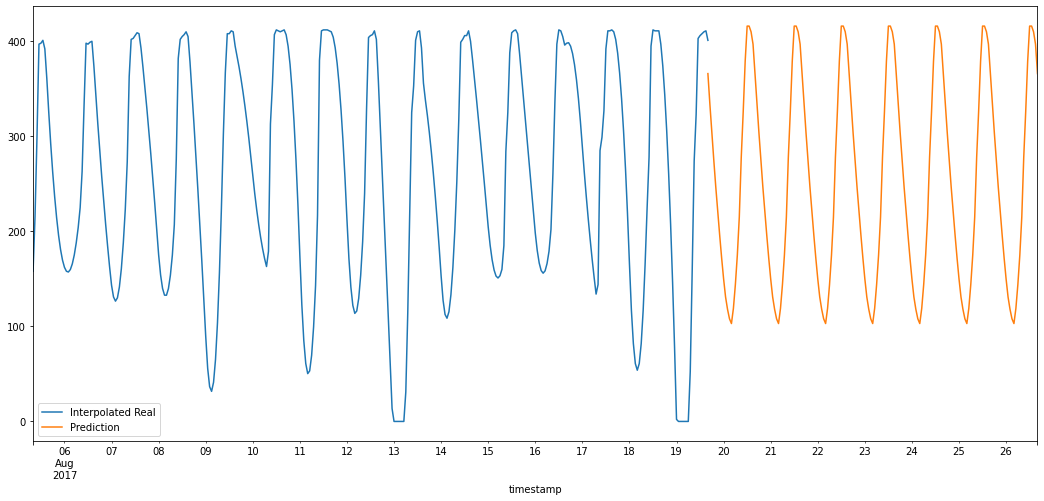

In [283]:
# municipal 1
fig,pred,error = get_pred(dt,1)
print("Sarimax MSE error: " + str(error))
print(pred)

Sarimax MSE error: 3026.7460261201427
2017-08-19 16:00:00    366.0
2017-08-19 17:00:00    334.0
2017-08-19 18:00:00    304.0
2017-08-19 19:00:00    275.0
2017-08-19 20:00:00    247.0
                       ...  
2017-08-26 12:00:00    416.0
2017-08-26 13:00:00    416.0
2017-08-26 14:00:00    410.0
2017-08-26 15:00:00    397.0
2017-08-26 16:00:00    366.0
Freq: H, Name: predicted_mean, Length: 169, dtype: float64


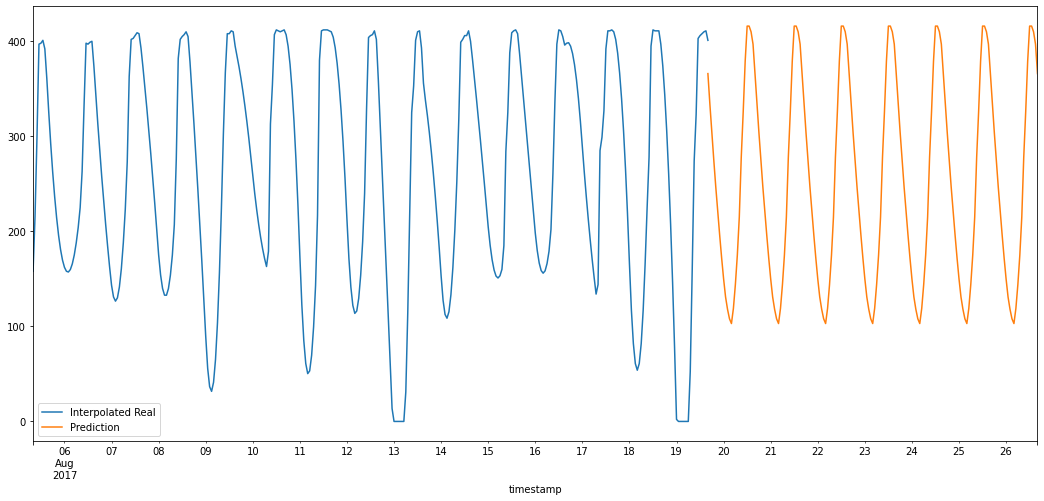

In [287]:
# municipal 1
fig,pred,error = get_pred(dt,1)
print('Sarimax MSE error: ' + str(error))
print(pred)
 

Sarimax MSE error: 15407.939780698976
2017-08-19 16:00:00    553.0
2017-08-19 17:00:00    511.0
2017-08-19 18:00:00    467.0
2017-08-19 19:00:00    424.0
2017-08-19 20:00:00    382.0
                       ...  
2017-08-26 12:00:00    661.0
2017-08-26 13:00:00    681.0
2017-08-26 14:00:00    648.0
2017-08-26 15:00:00    592.0
2017-08-26 16:00:00    553.0
Freq: H, Name: predicted_mean, Length: 169, dtype: float64


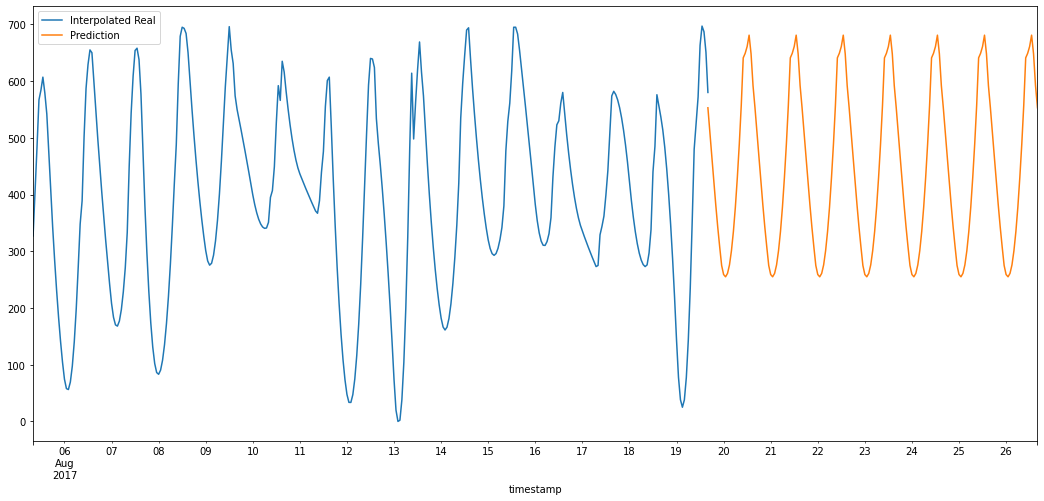

In [288]:
# municipal 2
fig,pred,error = get_pred(dt,2)
print('Sarimax MSE error: ' + str(error))
print(pred)

Sarimax MSE error: 71478.849520849
2017-08-19 16:00:00    1019.0
2017-08-19 17:00:00     790.0
2017-08-19 18:00:00     591.0
2017-08-19 19:00:00     423.0
2017-08-19 20:00:00     285.0
                        ...  
2017-08-26 12:00:00    1460.0
2017-08-26 13:00:00    1441.0
2017-08-26 14:00:00    1402.0
2017-08-26 15:00:00    1259.0
2017-08-26 16:00:00    1019.0
Freq: H, Name: predicted_mean, Length: 169, dtype: float64


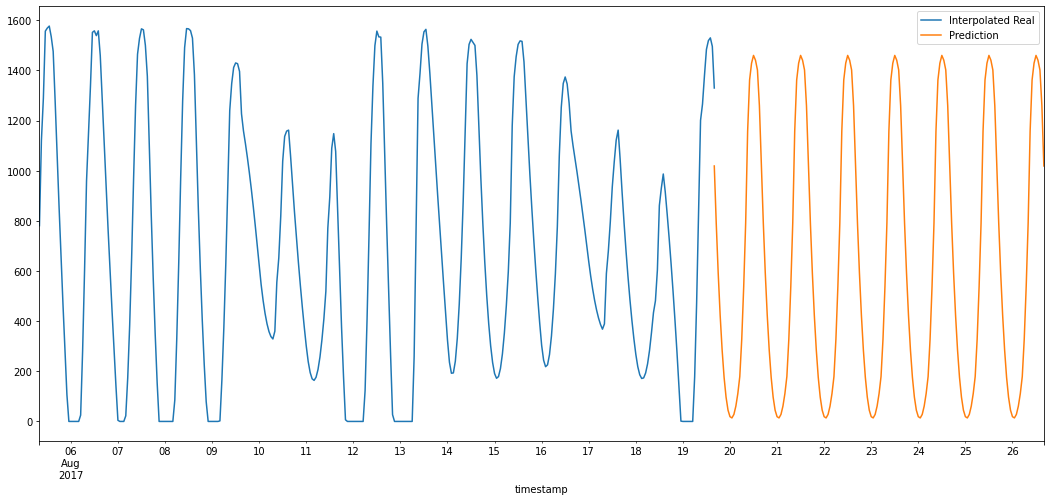

In [289]:
# municipal 3
fig,pred,error = get_pred(dt,3)
print('Sarimax MSE error: ' + str(error))
print(pred)

Sarimax MSE error: 346274.17103190924
2017-08-19 16:00:00    2295.0
2017-08-19 17:00:00    1838.0
2017-08-19 18:00:00    1441.0
2017-08-19 19:00:00    1101.0
2017-08-19 20:00:00     816.0
                        ...  
2017-08-26 12:00:00    3158.0
2017-08-26 13:00:00    3135.0
2017-08-26 14:00:00    3069.0
2017-08-26 15:00:00    2779.0
2017-08-26 16:00:00    2295.0
Freq: H, Name: predicted_mean, Length: 169, dtype: float64


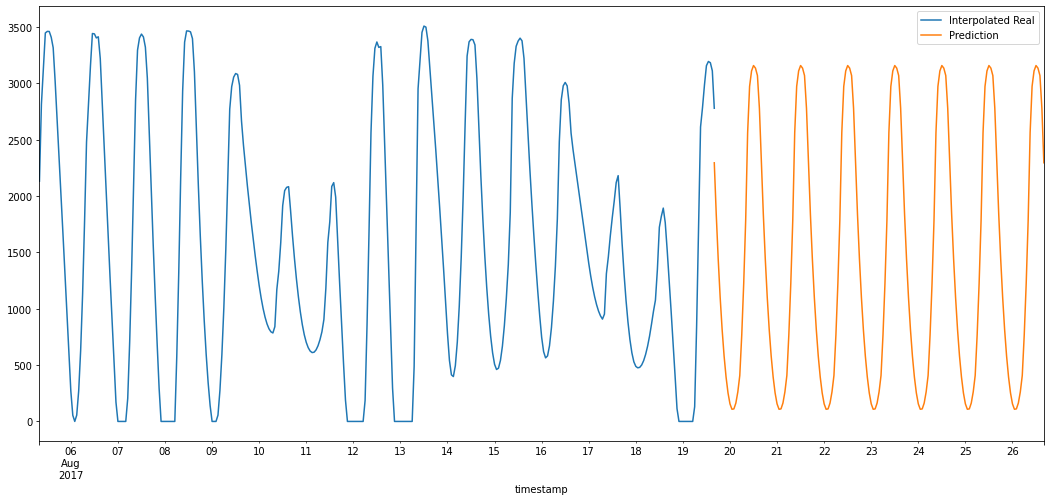

In [290]:
# municipal 4
fig,pred,error = get_pred(dt,4)
print('Sarimax MSE error: ' + str(error))
print(pred)

Sarimax MSE error: 5404.104260044912
2017-08-19 16:00:00    114.0
2017-08-19 17:00:00     74.0
2017-08-19 18:00:00     41.0
2017-08-19 19:00:00     16.0
2017-08-19 20:00:00      4.0
                       ...  
2017-08-26 12:00:00    210.0
2017-08-26 13:00:00    211.0
2017-08-26 14:00:00    190.0
2017-08-26 15:00:00    158.0
2017-08-26 16:00:00    114.0
Freq: H, Name: predicted_mean, Length: 169, dtype: float64


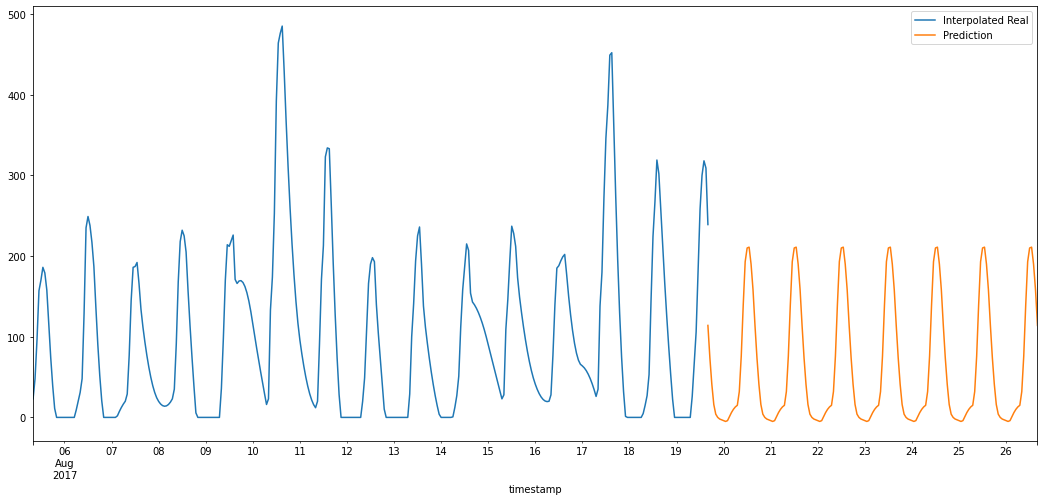

In [291]:
# municipal 5
fig,pred,error = get_pred(dt,5)
print('Sarimax MSE error: ' + str(error))
print(pred)

Sarimax MSE error: 133524.82366458187
2017-08-19 16:00:00    1010.0
2017-08-19 17:00:00     934.0
2017-08-19 18:00:00     853.0
2017-08-19 19:00:00     772.0
2017-08-19 20:00:00     694.0
                        ...  
2017-08-26 12:00:00    1182.0
2017-08-26 13:00:00    1204.0
2017-08-26 14:00:00    1169.0
2017-08-26 15:00:00    1075.0
2017-08-26 16:00:00    1010.0
Freq: H, Name: predicted_mean, Length: 169, dtype: float64


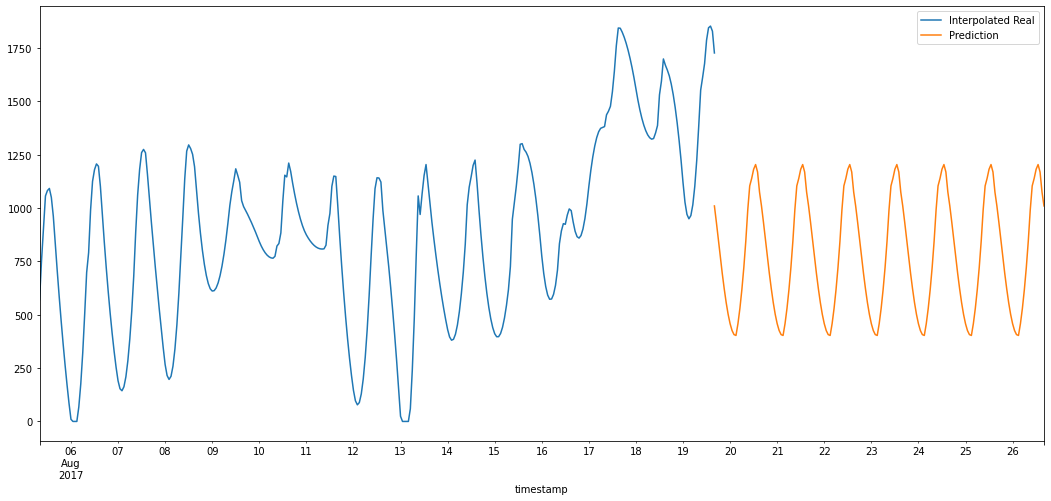

In [292]:
# municipal 6
fig,pred,error = get_pred(dt,6)
print('Sarimax MSE error: ' + str(error))
print(pred)

Sarimax MSE error: 46546.464302542954
2017-08-19 16:00:00    1218.0
2017-08-19 17:00:00    1091.0
2017-08-19 18:00:00     972.0
2017-08-19 19:00:00     862.0
2017-08-19 20:00:00     762.0
                        ...  
2017-08-26 12:00:00    1486.0
2017-08-26 13:00:00    1521.0
2017-08-26 14:00:00    1472.0
2017-08-26 15:00:00    1351.0
2017-08-26 16:00:00    1218.0
Freq: H, Name: predicted_mean, Length: 169, dtype: float64


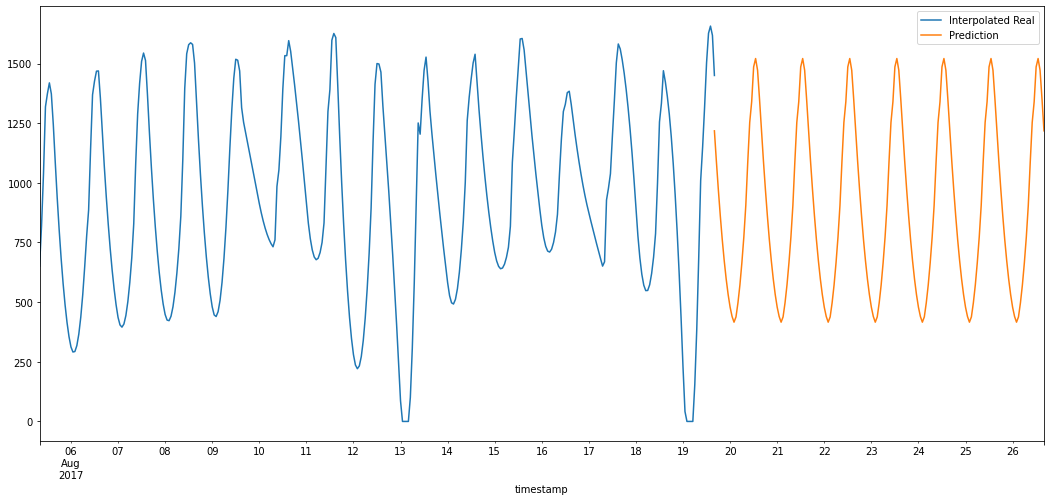

In [293]:
# municipal 7
fig,pred,error = get_pred(dt,7)
print('Sarimax MSE error: ' + str(error))
print(pred)

Sarimax MSE error: 47857.36827449564
2017-08-19 16:00:00    1096.0
2017-08-19 17:00:00     955.0
2017-08-19 18:00:00     822.0
2017-08-19 19:00:00     698.0
2017-08-19 20:00:00     584.0
                        ...  
2017-08-26 12:00:00    1314.0
2017-08-26 13:00:00    1337.0
2017-08-26 14:00:00    1307.0
2017-08-26 15:00:00    1234.0
2017-08-26 16:00:00    1096.0
Freq: H, Name: predicted_mean, Length: 169, dtype: float64


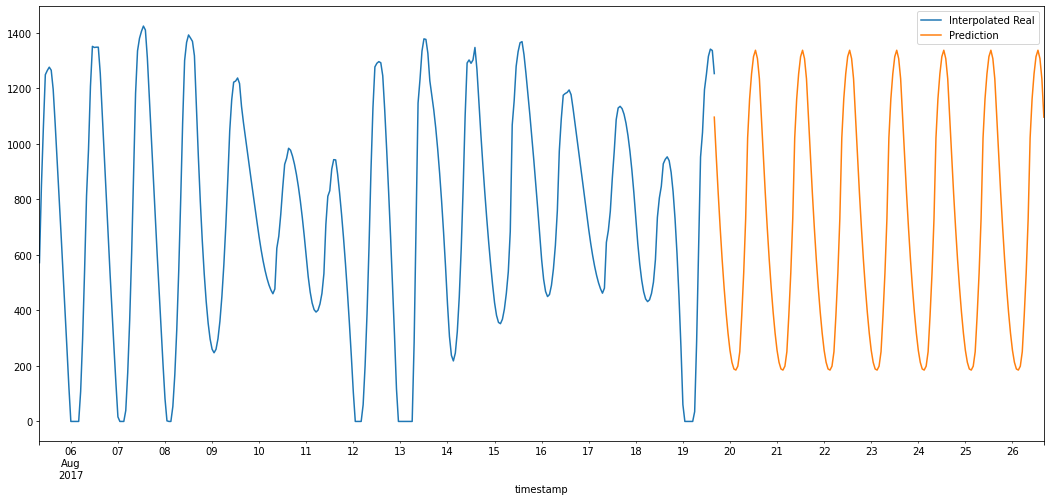

In [294]:
# municipal 8
fig,pred,error = get_pred(dt,8)
print('Sarimax MSE error: ' + str(error))
print(pred)
 

Sarimax MSE error: 20755.913458070085
2017-08-19 16:00:00    676.0
2017-08-19 17:00:00    591.0
2017-08-19 18:00:00    515.0
2017-08-19 19:00:00    447.0
2017-08-19 20:00:00    389.0
                       ...  
2017-08-26 12:00:00    839.0
2017-08-26 13:00:00    853.0
2017-08-26 14:00:00    836.0
2017-08-26 15:00:00    770.0
2017-08-26 16:00:00    676.0
Freq: H, Name: predicted_mean, Length: 169, dtype: float64


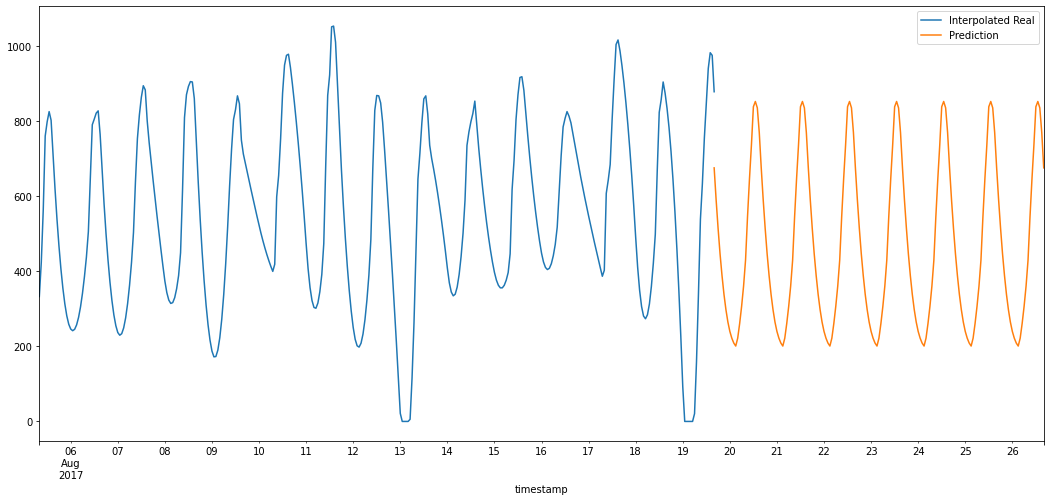

In [295]:
# municipal 9
fig,pred,error = get_pred(dt,9)
print('Sarimax MSE error: ' + str(error))
print(pred)
 

# Better models can be found by also considering weekly seasonality. 
# Our first assumption (each municipality will have similar dynamics) was wrong! 
# Most municipalities show strong weekly patterns. However first one doesn't show a strong weekly pattern. 
(Make sense in retrospect)